In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [4]:
train = pd.read_csv('../input/train.csv', index_col="Id")
test = pd.read_csv('../input/test.csv', index_col="Id")


train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

# Exploratory Data Analysis

## Check for multicollinearity

### Correlation Matrix


<Axes: >

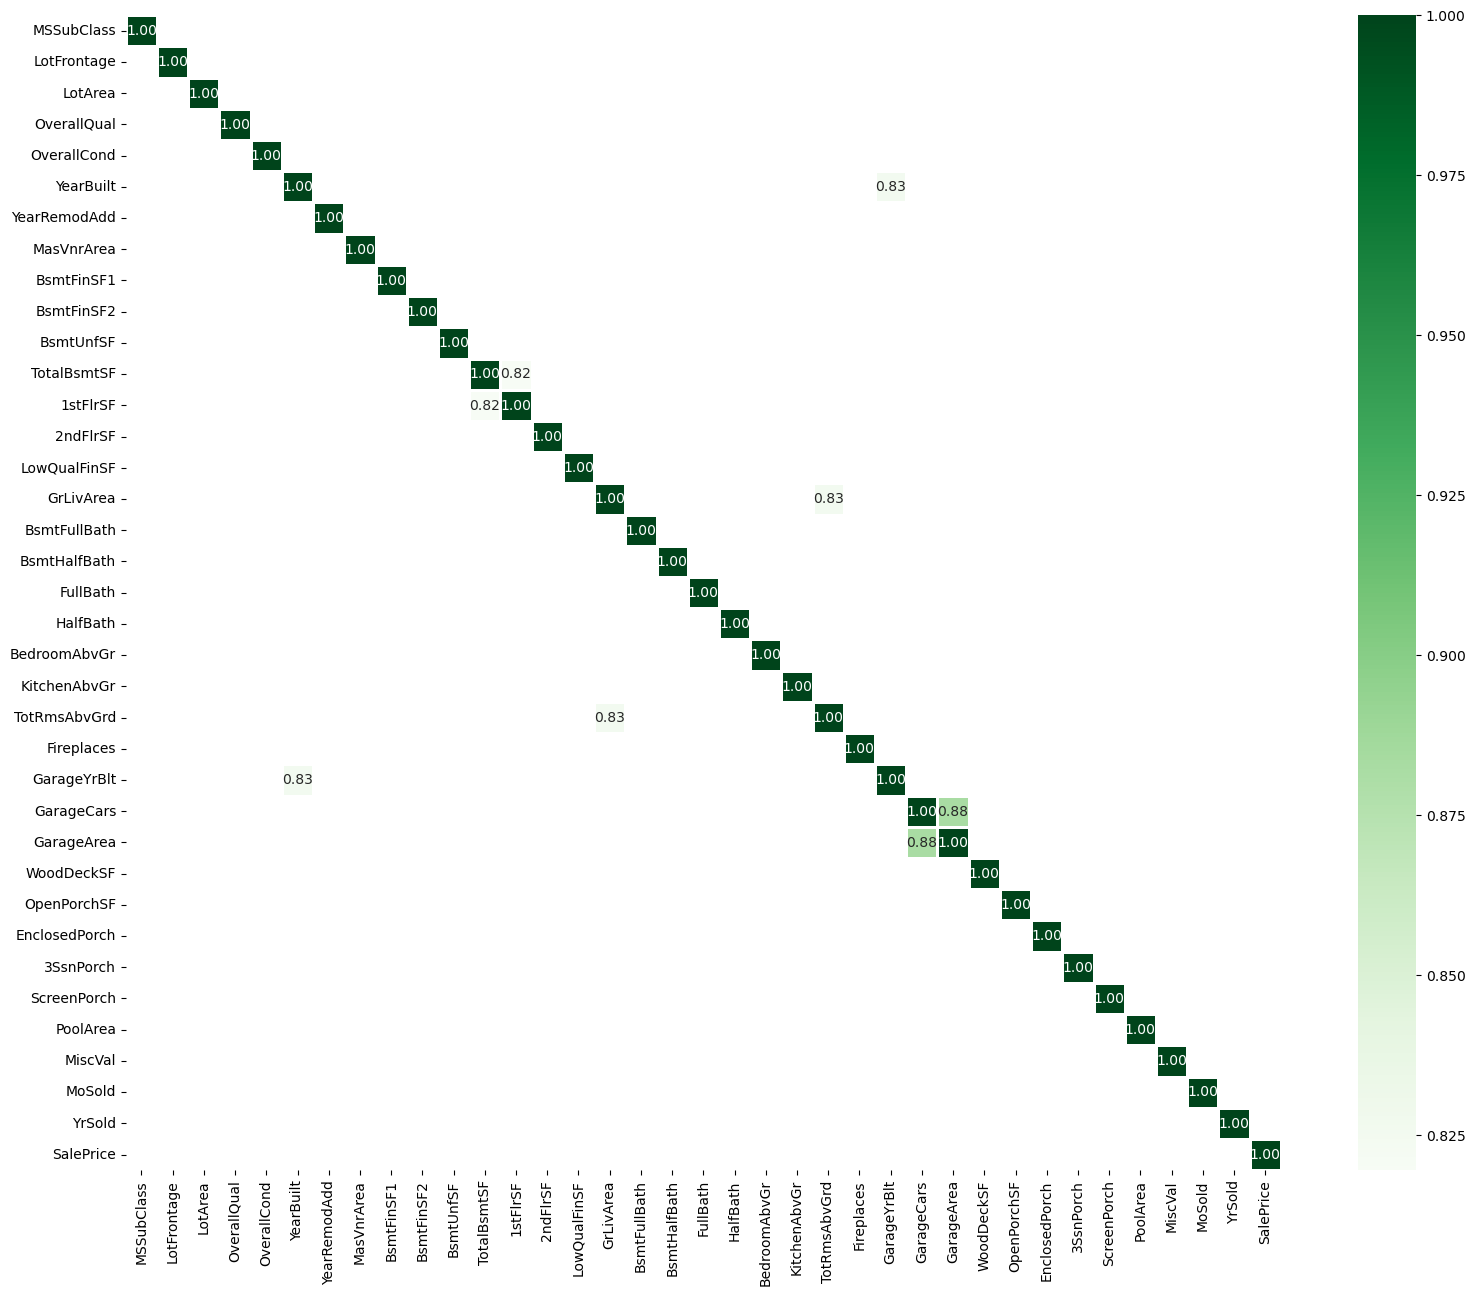

In [17]:
threshold = 0.8

correlation_matrix = train.corr(numeric_only=True)

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, 
            mask=correlation_matrix<threshold, 
            annot = True,
            linewidths = 2,
            fmt = ".2f",
            square = True,
            cmap='Greens')

### High Inter Correlated Features (T=0.8)

In [24]:
threshold = 0.8
high_corr_pairs = []

# Loop through each pair of features in the correlation matrix
for feature_col in correlation_matrix.columns:
    for feature_row in correlation_matrix.columns:
        if feature_row == feature_col:
            continue
        correlation_value = abs(correlation_matrix.loc[feature_row, feature_col])
        if correlation_value > threshold:
            high_corr_pairs.append((feature_row, feature_col, correlation_value))

high_corr_train = pd.DataFrame(high_corr_pairs, columns=["feature_row", "feature_col", "Correlation"])
high_corr_train = high_corr_train.sort_values(by="Correlation", ascending=False).drop_duplicates(subset=["Correlation"])

print(high_corr_train)

    feature_row  feature_col  Correlation
6    GarageArea   GarageCars     0.882475
0   GarageYrBlt    YearBuilt     0.825667
3  TotRmsAbvGrd    GrLivArea     0.825489
1      1stFlrSF  TotalBsmtSF     0.819530


### High Correlted to SalePrice


In [29]:
saleprice_corr = correlation_matrix['SalePrice'].sort_values(ascending=False)
saleprice_corr.head(11)


SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

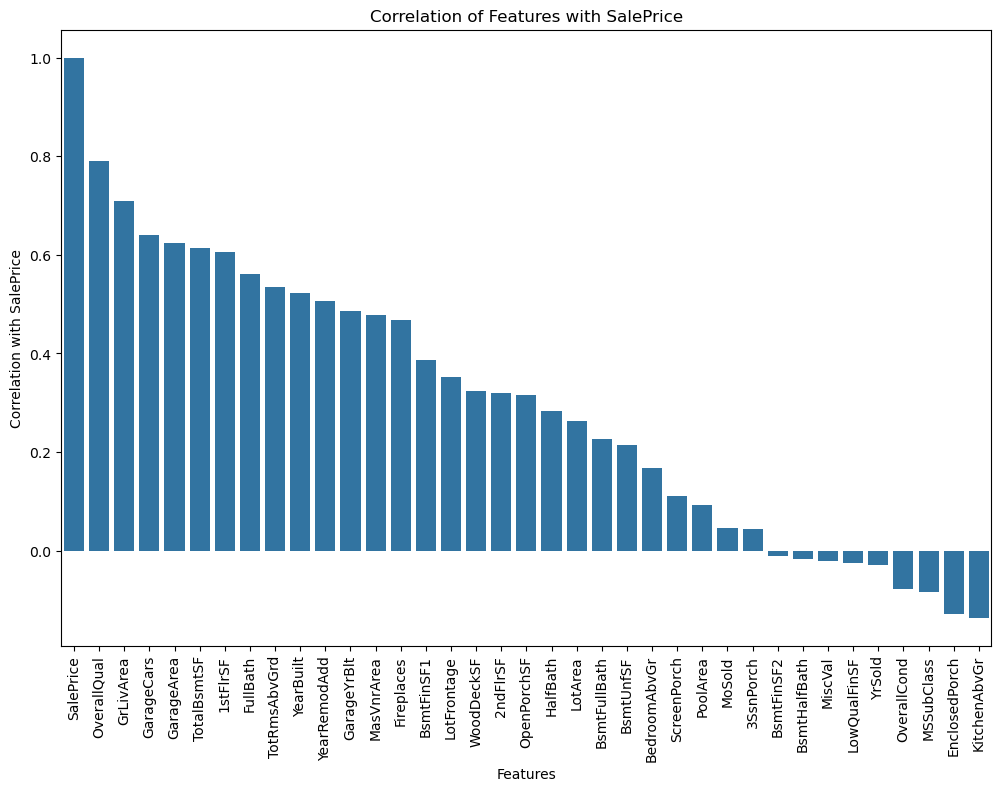

In [32]:
plt.figure(figsize=(12, 8))
sns.barplot(x=saleprice_corr.index, y=saleprice_corr.values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Correlation with SalePrice')
plt.title('Correlation of Features with SalePrice')
plt.show()

## Missing Values

In [37]:
# Check missing values percentage
missing = pd.DataFrame(train.isnull().sum().sort_values(ascending=False))
missing.columns = ["Counts"]
missing = missing.loc[(missing != 0).any(axis=1)]

missing["Percentage"] = missing[0:] / 1460
missing.style.background_gradient("Greens")

,Counts,Percentage
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479


## Scatter Plot (X=feature, y=SalePrice)

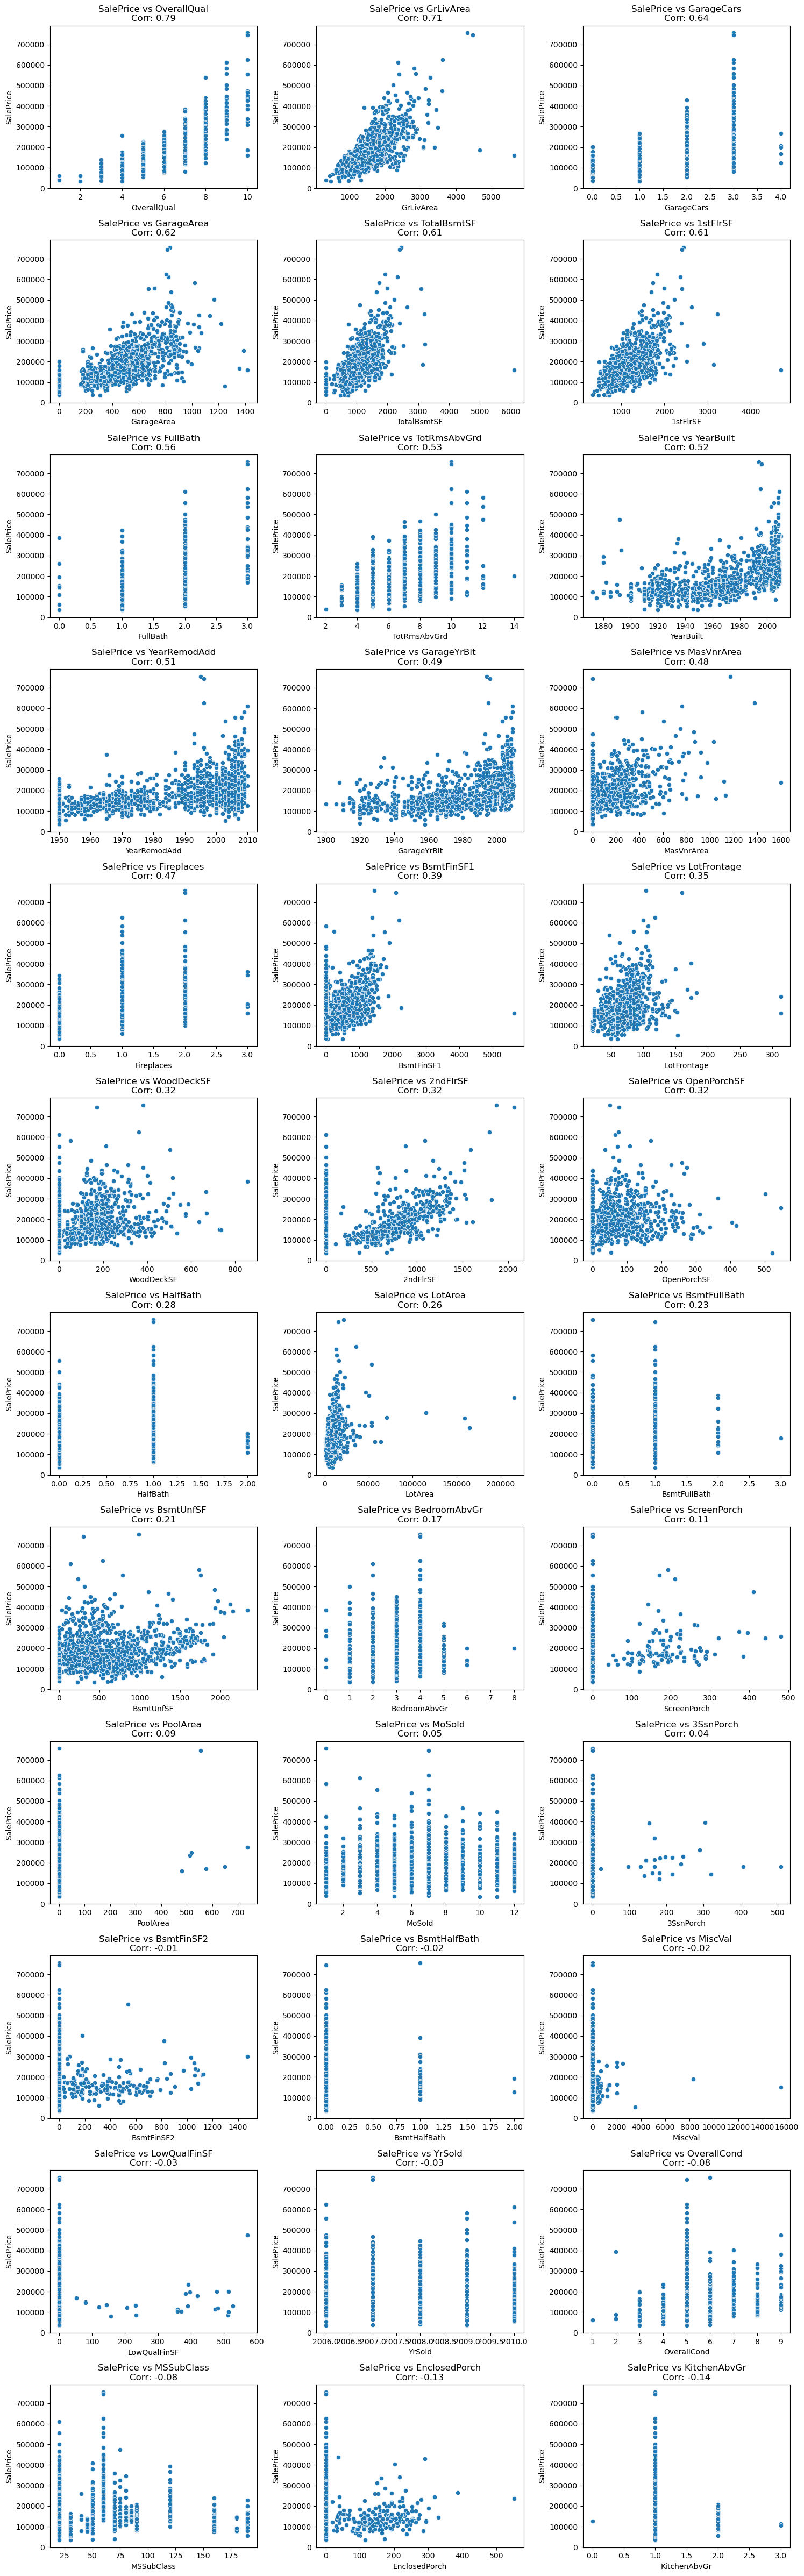

In [42]:
import math

# Assume correlation_matrix has been computed and is available
saleprice_corr = correlation_matrix['SalePrice'].sort_values(ascending=False)

# Remove SalePrice itself from the features list
features = saleprice_corr.drop('SalePrice').index.tolist()

# Calculate grid dimensions: 3 plots per row
num_plots = len(features)
cols = 3
rows = math.ceil(num_plots / cols)

# Create the subplots grid
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()  # Flatten in case of a 2D array

# Loop through the sorted features and create scatter plots against SalePrice
for i, feature in enumerate(features):
    sns.scatterplot(data=train, x=feature, y='SalePrice', ax=axes[i])
    # Optionally, display the correlation value in the title
    axes[i].set_title(f'SalePrice vs {feature}\nCorr: {saleprice_corr[feature]:.2f}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('SalePrice')

# Remove any unused subplots (if total features is not a multiple of 3)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Pairplot of TOP 5 correlated Features

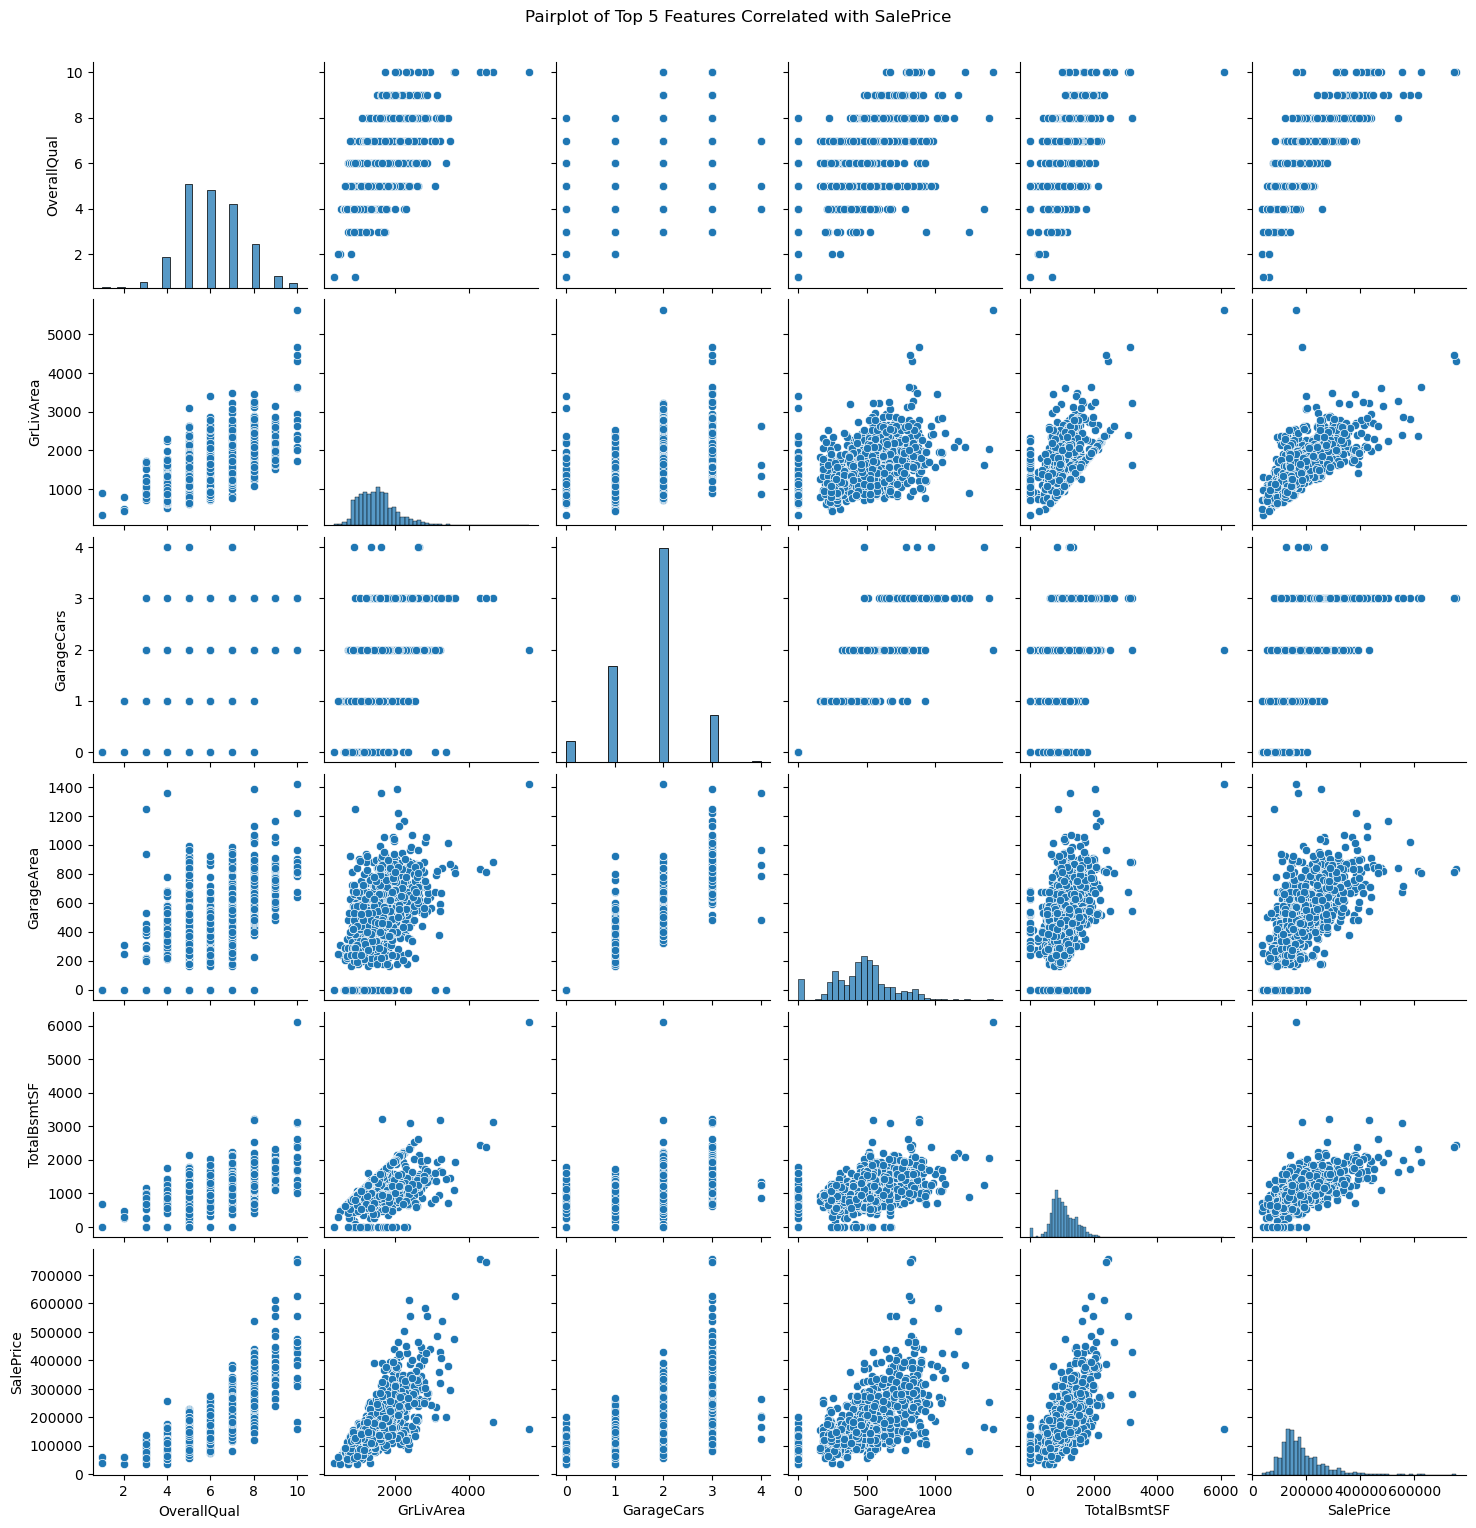

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume correlation_matrix has been computed
saleprice_corr = correlation_matrix['SalePrice'].sort_values(ascending=False)

# Get the top 5 features correlated with SalePrice (excluding SalePrice itself)
top5_features = saleprice_corr.drop('SalePrice').head(5).index.tolist()

# Create a list of columns to include in the pairplot (including SalePrice)
cols = top5_features + ['SalePrice']

# Generate the pairplot
sns.pairplot(train[cols])
plt.suptitle("Pairplot of Top 5 Features Correlated with SalePrice", y=1.02)
plt.show()

## Top 10 target correlated Outliers

In [64]:
high_target_corr_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd',
'YearBuilt', 'YearRemodAdd']

### IQR

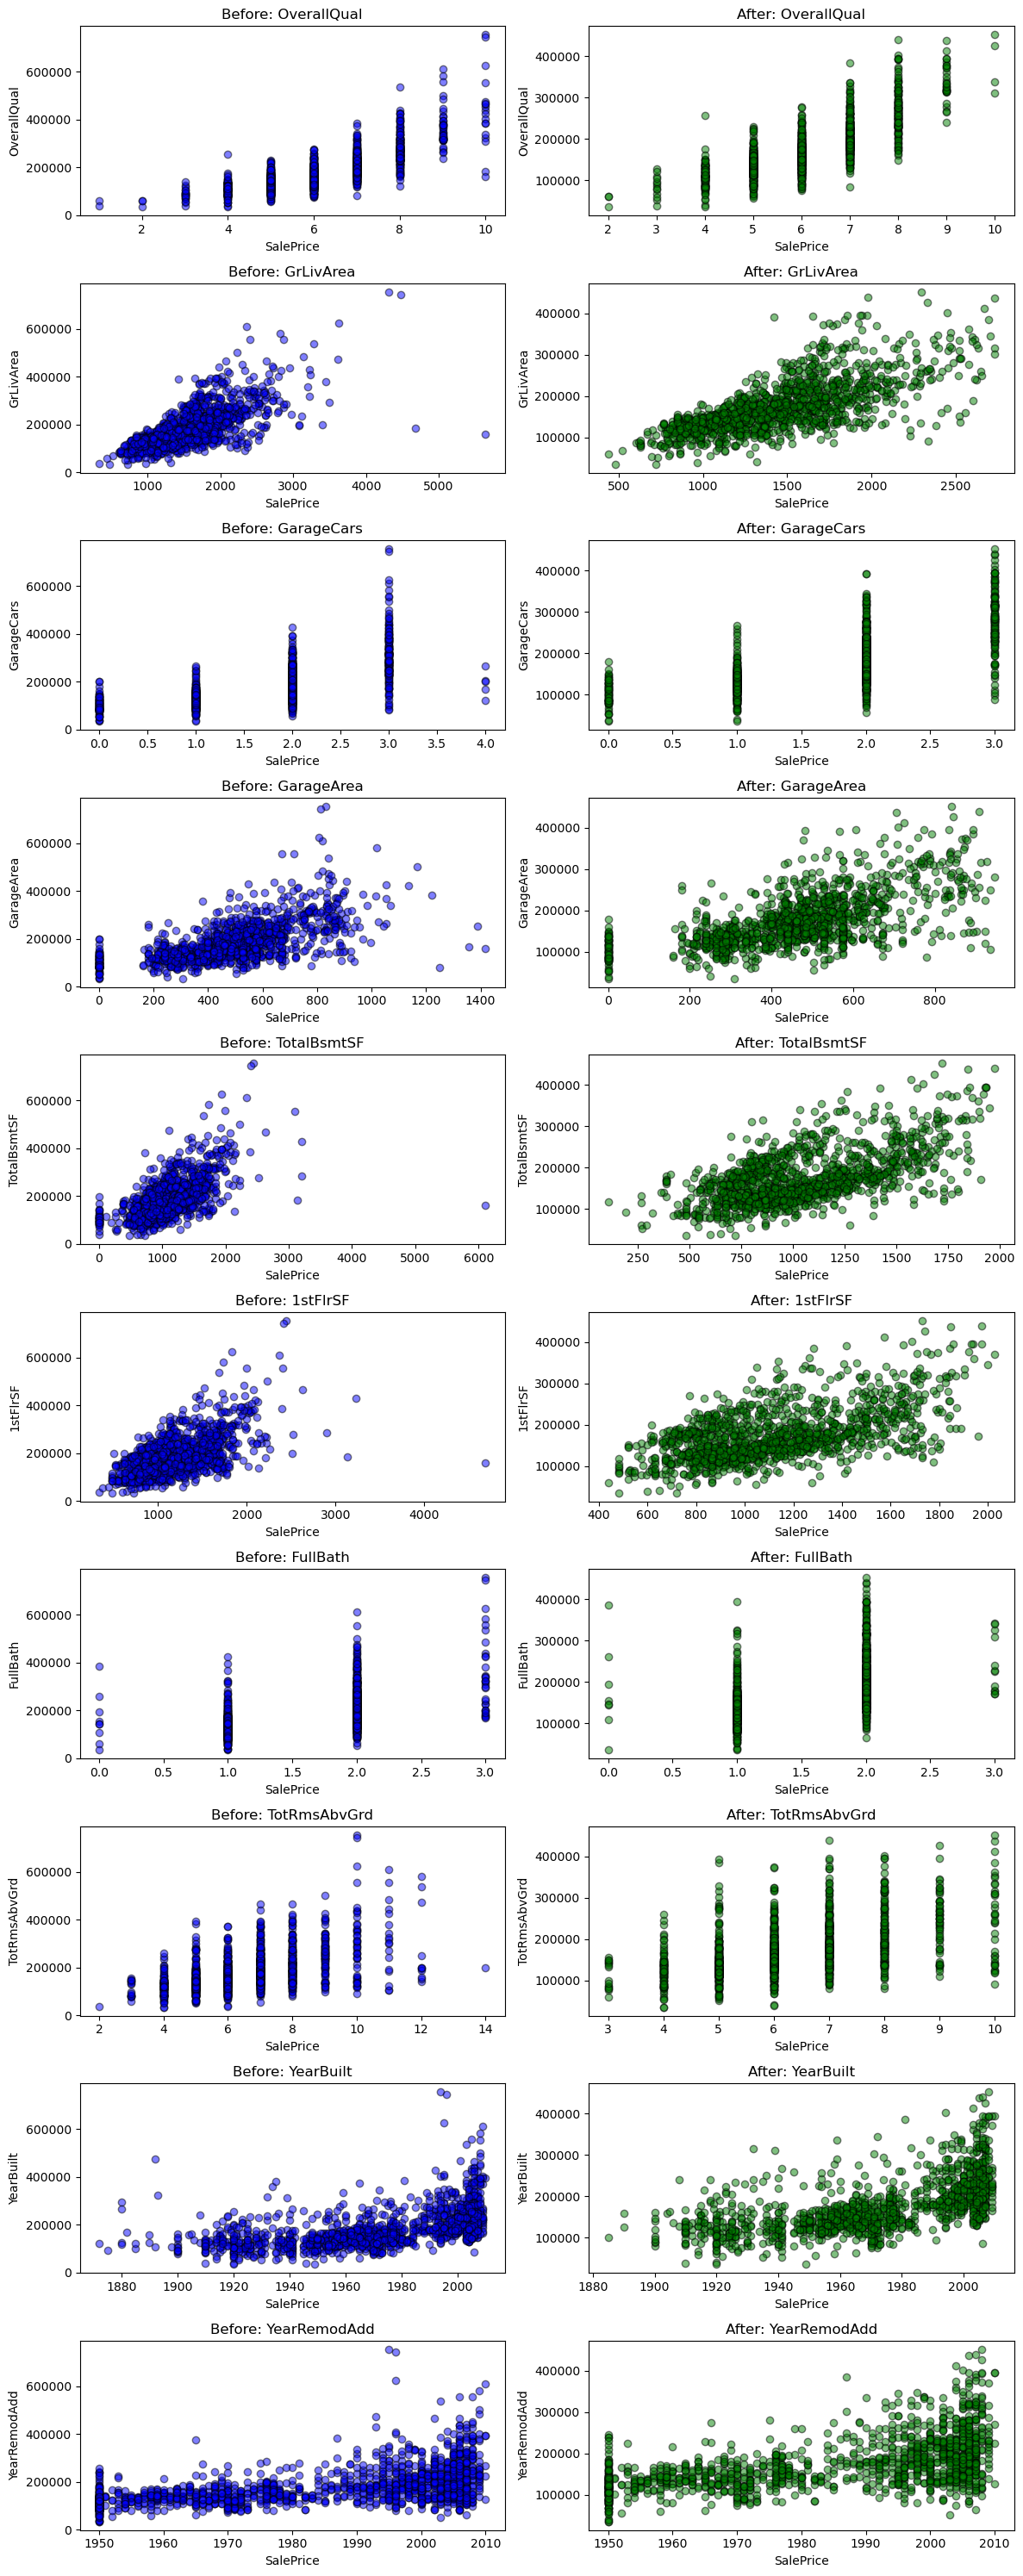

In [68]:
# Suppose train is your DataFrame and these are the variables of interest:
variables = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 
             'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 
             'YearBuilt', 'YearRemodAdd']

# Optionally, if you have a target variable (e.g., 'SalePrice'), you could use that for plotting:
target = 'SalePrice'  # If available; otherwise, you can plot against the index.

# Make copies for plotting before outlier removal
df_before = train.copy()
df_after = train.copy()

# Function to remove outliers using IQR method for a given column
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Remove outliers for each variable sequentially:
for col in variables:
    df_after = remove_outliers(df_after, col)

# Now, create scatter plots before and after outlier removal.
# Here, we’ll plot each variable vs. the target if available, otherwise vs. index.
num_vars = len(variables)
fig, axes = plt.subplots(num_vars, 2, figsize=(12, num_vars * 3))
for i, col in enumerate(variables):
    # Choose x-axis data: target if exists, else the index
    if target in train.columns:
        x_before = df_before[target]
        x_after = df_after[target]
    else:
        x_before = df_before.index
        x_after = df_after.index

    # Plot before outlier removal
    axes[i, 0].scatter(df_before[col], x_before,  alpha=0.5, color='blue', edgecolor='k')
    axes[i, 0].set_title(f'Before: {col}')
    axes[i, 0].set_xlabel(target if target in train.columns else 'Index')
    axes[i, 0].set_ylabel(col)
    
    # Plot after outlier removal
    axes[i, 1].scatter(df_after[col], x_after,  alpha=0.5, color='green', edgecolor='k')
    axes[i, 1].set_title(f'After: {col}')
    axes[i, 1].set_xlabel(target if target in train.columns else 'Index')
    axes[i, 1].set_ylabel(col)

plt.tight_layout()
plt.show()

### Box Plot

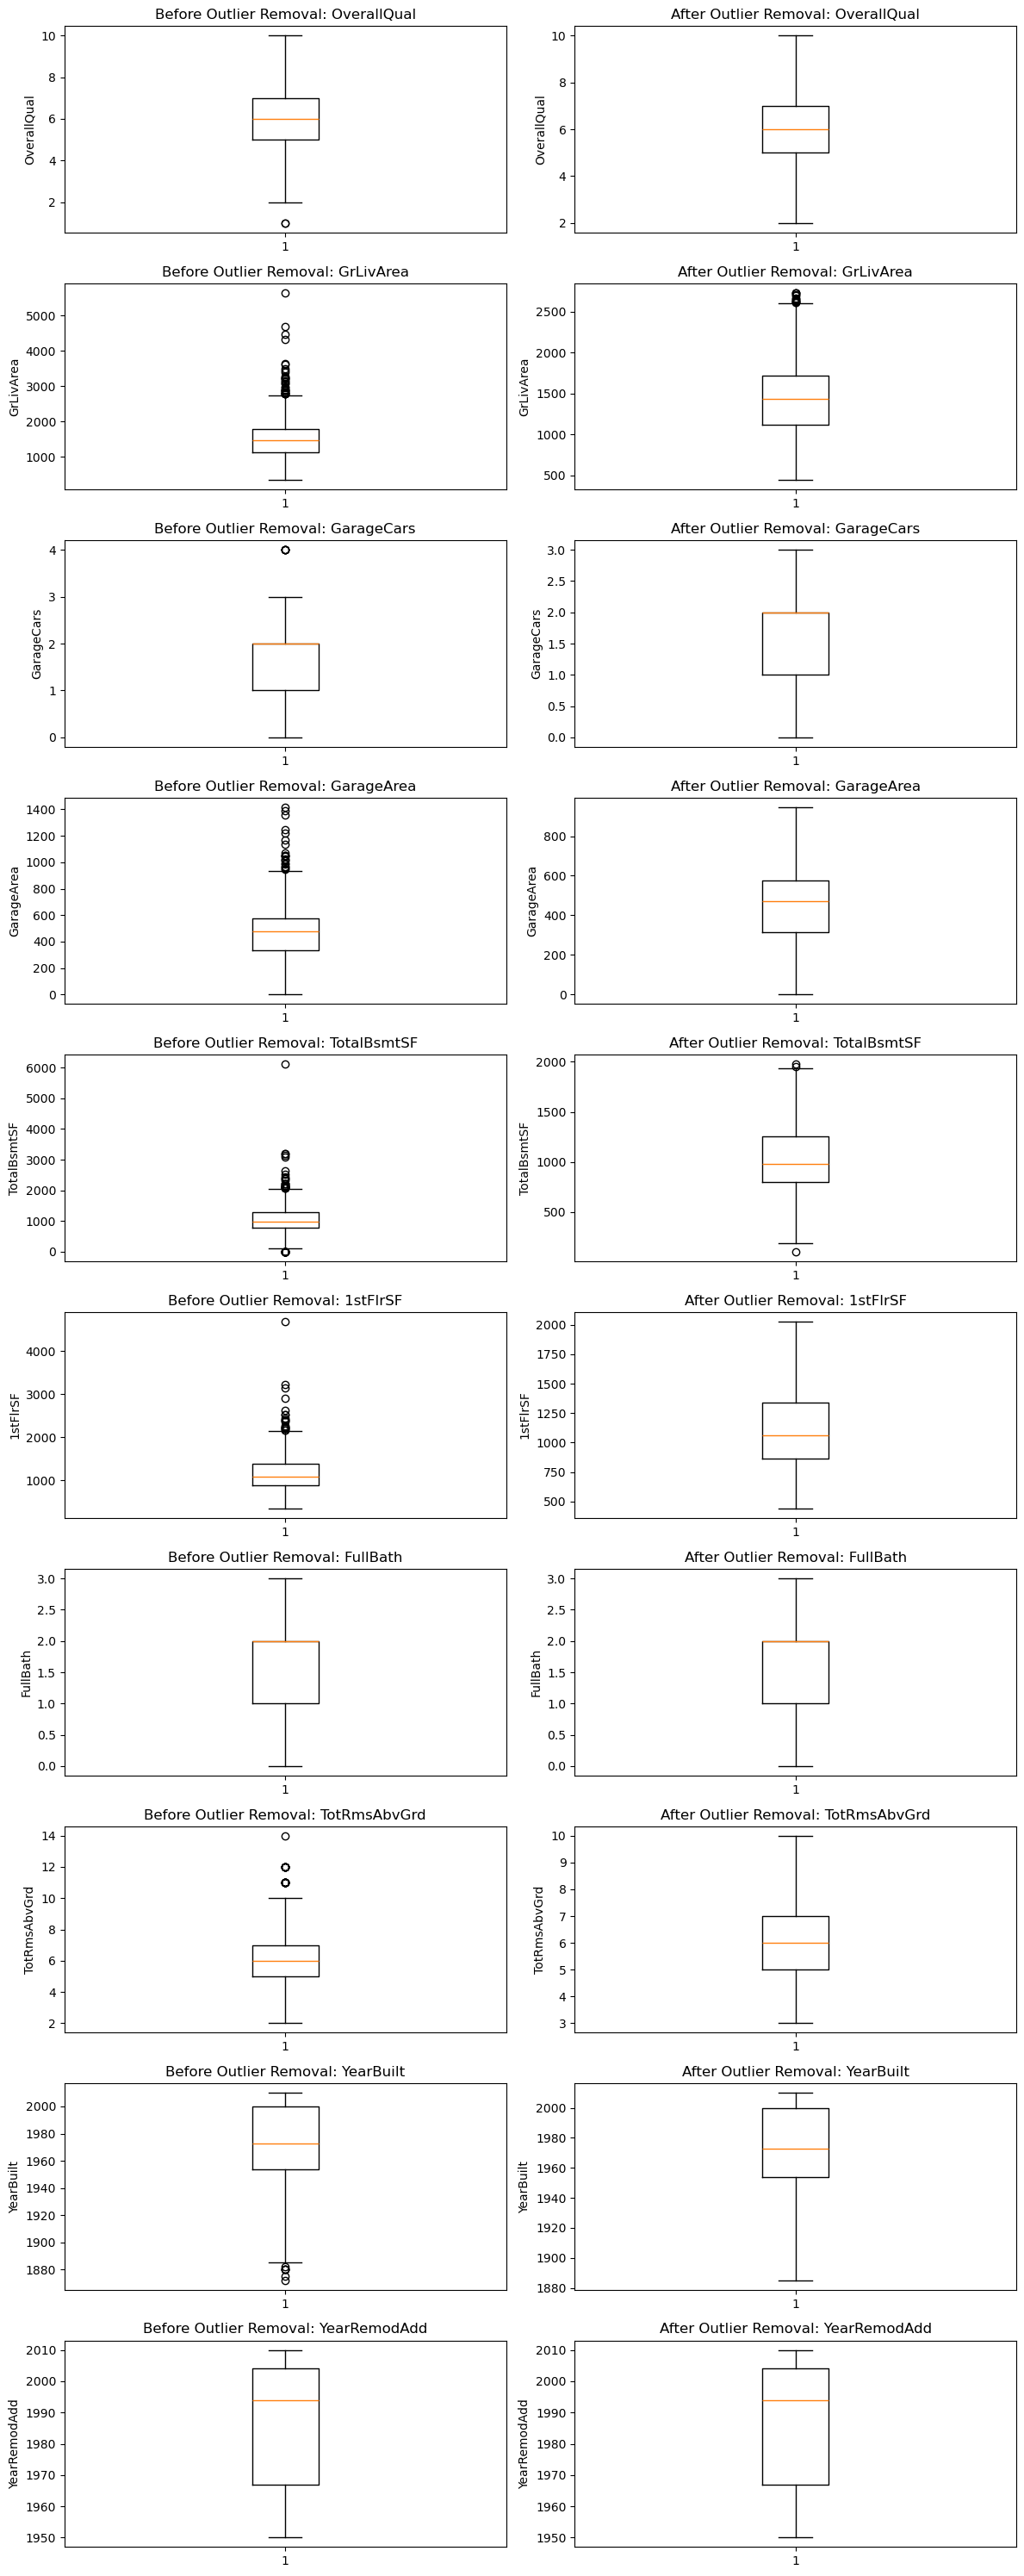

In [71]:
import matplotlib.pyplot as plt

# Create boxplots for before and after outlier removal.
num_vars = len(variables)
fig, axes = plt.subplots(num_vars, 2, figsize=(12, num_vars * 3))

for i, col in enumerate(variables):
    # Boxplot for the variable before outlier removal
    axes[i, 0].boxplot(df_before[col].dropna())
    axes[i, 0].set_title(f'Before Outlier Removal: {col}')
    axes[i, 0].set_ylabel(col)
    
    # Boxplot for the variable after outlier removal
    axes[i, 1].boxplot(df_after[col].dropna())
    axes[i, 1].set_title(f'After Outlier Removal: {col}')
    axes[i, 1].set_ylabel(col)

plt.tight_layout()
plt.show()


## Skew

In [91]:
skew_features = train.select_dtypes(exclude=['object']).skew().sort_values(ascending=False)
skew_features = pd.DataFrame({'Skew' : skew_features})
skew_features.style.background_gradient('Greens')

,Skew
MiscVal,24.476794
PoolArea,14.828374
LotArea,12.207688
3SsnPorch,10.304342
LowQualFinSF,9.011341
KitchenAbvGr,4.488397
BsmtFinSF2,4.255261
ScreenPorch,4.122214
BsmtHalfBath,4.103403
EnclosedPorch,3.089872
